# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Features selection on the Pima Indian dataset

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [17]:
from pylab import rcParams
from numpy import mean, std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest

# Load the dataset
<hr style = "border:2px solid black" ></hr>

In [4]:
# load the dataset
def load_dataset(filename):
    # load the dataset as a pandas DataFrame
    data = read_csv(filename, header=None)
    # retrieve numpy array
    dataset = data.values
    # split into input (X) and output (y) variables
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return X, y


# load the dataset
X, y = load_dataset('../DATASETS/pima-indians-diabetes.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)

# Model built using all features
<hr style = "border:2px solid black" ></hr>

In [5]:
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 77.56


# Feature selection
<hr style = "border:2px solid black" ></hr>

In [6]:
"""
We would prefer to use a subset of features that achieves a classification accuracy 
that is as good or better than this.
"""

'\nWe would prefer to use a subset of features that achieves a classification accuracy \nthat is as good or better than this.\n'

In [ ]:
# feature selection
def select_features(X_train, y_train, X_test, method):
    # configure to select a subset of features
    fs = SelectKBest(score_func=method, k=4)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

## Model built using features selected by ANOVA F-test 

In [7]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_classif)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 78.74


In [8]:
"""
In this case, we see that the model achieved an accuracy of about 78.74 percent, 
a lift in performance compared to the baseline that achieved 77.56 percent.
WHY is that happening?
"""

'\nIn this case, we see that the model achieved an accuracy of about 78.74 percent, \na lift in performance compared to the baseline that achieved 77.56 percent.\nWHY is that happening?\n'

## Model built using features selected via mutual information

In [9]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(
    X_train, y_train, X_test, mutual_info_classif)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 77.56


In [ ]:
"""
In this case, we can make no difference compared to the baseline model. 
This is interesting as we know the method chose a DIFFERENT four features
compared to the previous method.
"""

## Model built using an automatic feature selection

In [ ]:
"""
how do we know that is a good or best number of features to select? Instead of guessing, 
we can systematically test a range of different numbers of selected features and discover
which results in the best performing model. This is called a grid search, where the k 
argument to the SelectKBest class can be tuned. It is good practice to evaluate model
configurations on classification tasks using repeated stratified k-fold cross-validation.
We will use three repeats of 10-fold cross-validation via the RepeatedStratifiedKFold class.
"""

In [11]:
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the pipeline to evaluate
model = LogisticRegression(solver='liblinear')
# We have already seent that "f_classif" performed better than "mutual_info_classif"
fs = SelectKBest(score_func=f_classif)
pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
# define the grid
grid = dict()
grid['anova__k'] = [i+1 for i in range(X.shape[1])]
# define the grid search
search = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1, cv=cv)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)

Best Mean Accuracy: 0.770
Best Config: {'anova__k': 7}


In [ ]:
"""
We might want to see the relationship between the number of selected features and 
classification accuracy. m
"""

>1 0.748 (0.048)
>2 0.756 (0.042)
>3 0.761 (0.044)
>4 0.759 (0.042)
>5 0.770 (0.041)
>6 0.766 (0.042)
>7 0.770 (0.042)
>8 0.769 (0.040)


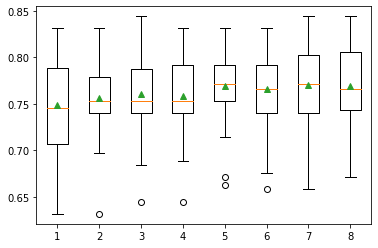

In [18]:
# evaluate a given model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores    

# define number of features to evaluate 
num_features = [i+1 for i in range(X.shape[1])]

# enumerate each number of features
results = list()
for k in num_features:
    # create pipeline
    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)]) # evaluate the model
    scores = evaluate_model(pipeline)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=num_features, showmeans=True)
pyplot.show()

In [ ]:
"""
In this case, it looks like selecting 5 or 7 features results in roughly the same accuracy.
Box and whisker plots are created side-by-side showing the trend of increasing mean accuracy with 
the number of selected features to five features, after which it may become less stable. Selecting
5 features might be an appropriate configuration in this case.
"""